In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

ras = [10000]
types = ["zero", "ppo", "random"]
splits = ["val", "test", "train"]


def check(check_f):
    for split in splits:
        for ra in ras:
            for t in types:
                path = f"../data/datasets/2D-control/{split}/ra{ra}/{t}.h5"
                with h5py.File(path, "r") as file:
                    check_f(file, path)

# Dataset Info

In [5]:
def dataset_info(file, path):
    print(
        f"file {path} has {file.attrs['episodes']} episodes with seed {file.attrs['base_seed']}"
    )


check(dataset_info)

file ../data/datasets/2D-control/val/ra10000/zero.h5 has 20 episodes with seed 400
file ../data/datasets/2D-control/val/ra10000/ppo.h5 has 20 episodes with seed 400
file ../data/datasets/2D-control/val/ra10000/random.h5 has 20 episodes with seed 400
file ../data/datasets/2D-control/test/ra10000/zero.h5 has 20 episodes with seed 800
file ../data/datasets/2D-control/test/ra10000/ppo.h5 has 20 episodes with seed 800
file ../data/datasets/2D-control/test/ra10000/random.h5 has 20 episodes with seed 800
file ../data/datasets/2D-control/train/ra10000/zero.h5 has 20 episodes with seed 100
file ../data/datasets/2D-control/train/ra10000/ppo.h5 has 20 episodes with seed 100
file ../data/datasets/2D-control/train/ra10000/random.h5 has 20 episodes with seed 100


# Validate Temperature

In [8]:
def validate(file, path):
    passed = True
    episodes = file.attrs["episodes"]
    steps = file.attrs["steps"]

    for episode in range(episodes):
        states = file[f"s-{episode}"]
        assert len(states) == steps, (
            f"Mismatch in number of steps for episode {episode}: expected {steps}, got {len(states)}"
        )

        for step in range(steps):
            assert states[step].shape == (3, 64, 96), (
                f"Unexpected shape at episode {episode}, step {step}: {states[step].shape}"
            )
            # validate temperature
            min, max = states[step][0].min(), states[step][0].max()
            if min < 1 or max > 2:
                print(
                    f"in file {path} at episode {episode} and step {step} - Temperature: min={min}, max={max}"
                )
                passed = False
    if not passed:
        print(f"File {path} failed validation.")
    else:
        print(
            f"File {path} passed validation with {episodes} episodes and {steps} steps each."
        )


check(validate)

File ../data/datasets/2D-control/val/ra10000/zero.h5 passed validation with 20 episodes and 400 steps each.
File ../data/datasets/2D-control/val/ra10000/ppo.h5 passed validation with 20 episodes and 400 steps each.
File ../data/datasets/2D-control/val/ra10000/random.h5 passed validation with 20 episodes and 400 steps each.
File ../data/datasets/2D-control/test/ra10000/zero.h5 passed validation with 20 episodes and 400 steps each.
File ../data/datasets/2D-control/test/ra10000/ppo.h5 passed validation with 20 episodes and 400 steps each.
File ../data/datasets/2D-control/test/ra10000/random.h5 passed validation with 20 episodes and 400 steps each.
File ../data/datasets/2D-control/train/ra10000/zero.h5 passed validation with 20 episodes and 400 steps each.
File ../data/datasets/2D-control/train/ra10000/ppo.h5 passed validation with 20 episodes and 400 steps each.
File ../data/datasets/2D-control/train/ra10000/random.h5 passed validation with 20 episodes and 400 steps each.


# Mean, Min and Max per channel

Calculating mean, min, max for split val


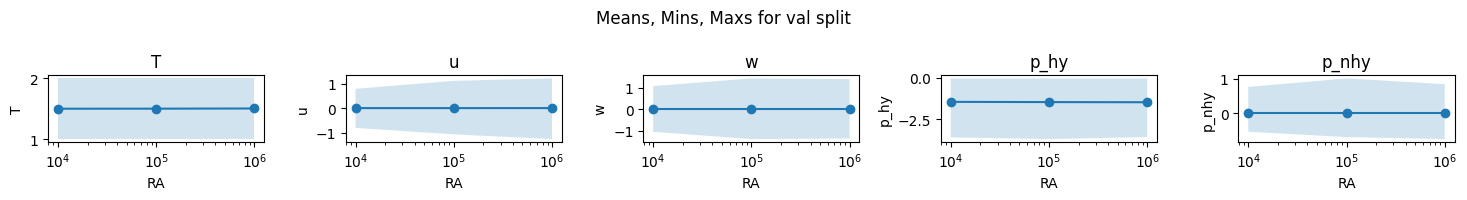

Calculating mean, min, max for split test


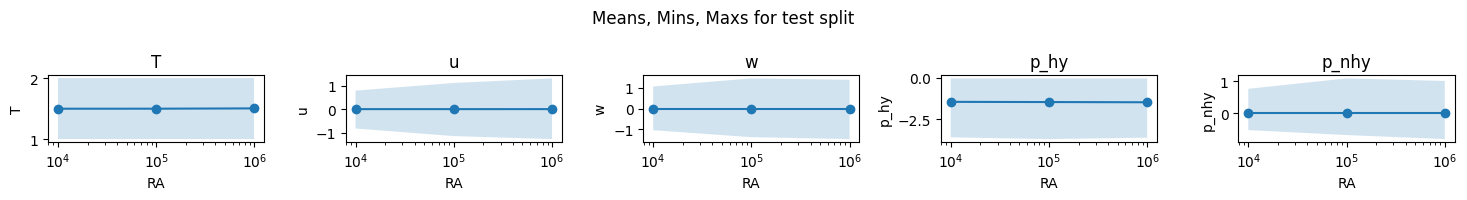

Calculating mean, min, max for split train


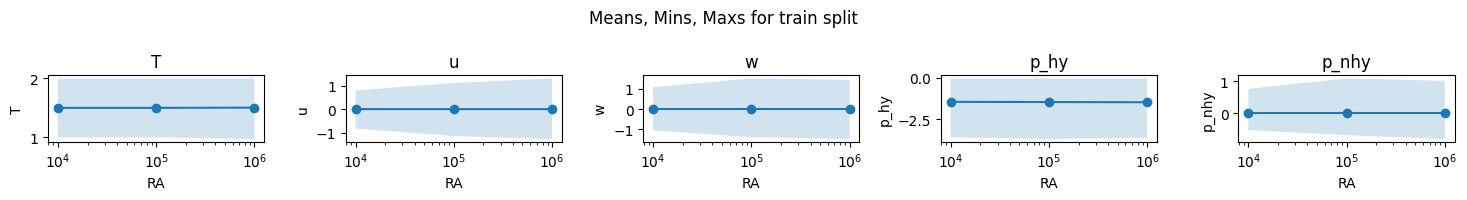

In [81]:
def mmm(file, path):
    episodes = file.attrs["episodes"]

    channels = ["T", "u", "w", "p_hy", "p_nhy"]
    means, mins, maxs = {}, {}, {}
    for name in channels:
        means[name] = []
        mins[name] = []
        maxs[name] = []

    for episode in range(episodes):
        # print mean, min, max per channel
        states = np.array(file[f"states{episode}"])

        for ch, name in enumerate(channels):
            means[name].append(states[:, ch, :, :].mean())
            mins[name].append(states[:, ch, :, :].min())
            maxs[name].append(states[:, ch, :, :].max())

    means = {k: np.mean(v) for k, v in means.items()}
    mins = {k: np.min(v) for k, v in mins.items()}
    maxs = {k: np.max(v) for k, v in maxs.items()}
    return means, mins, maxs


for split in splits:
    print(f"Calculating mean, min, max for split {split}")
    channels = ["T", "u", "w", "p_hy", "p_nhy"]
    means, mins, maxs = {}, {}, {}
    for name in channels:
        means[name] = []
        mins[name] = []
        maxs[name] = []

    for ra in ras:
        path = f"../data/datasets/2D/{split}/ra{ra}.h5"
        with h5py.File(path, "r") as file:
            mean, min, max = mmm(file, path)
            for name in channels:
                means[name].append(mean[name])
                mins[name].append(min[name])
                maxs[name].append(max[name])

    # plot means, mins, maxs
    fig, axs = plt.subplots(1, 5, figsize=(15, 2))
    fig.suptitle(f"Means, Mins, Maxs for {split} split")
    for i, name in enumerate(channels):
        axs[i].plot(ras, means[name], label="Mean", marker="o")
        axs[i].fill_between(
            ras, mins[name], maxs[name], alpha=0.2, label="Min-Max Range"
        )
        axs[i].set_title(name)
        axs[i].set_xlabel("RA")
        axs[i].set_ylabel(name)
        axs[i].set_xscale("log")
    plt.tight_layout()
    plt.show()

# Nusselt Number

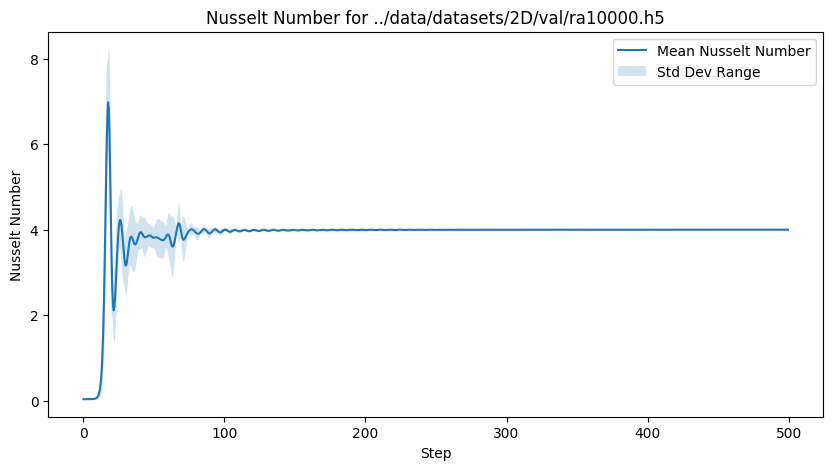

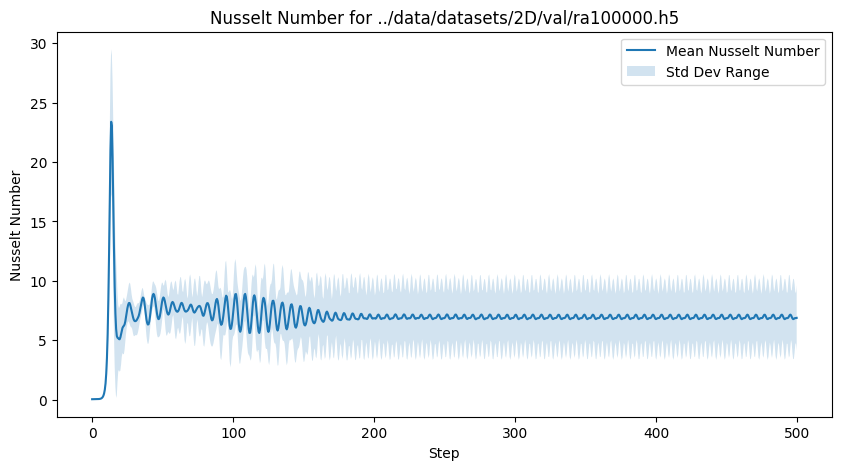

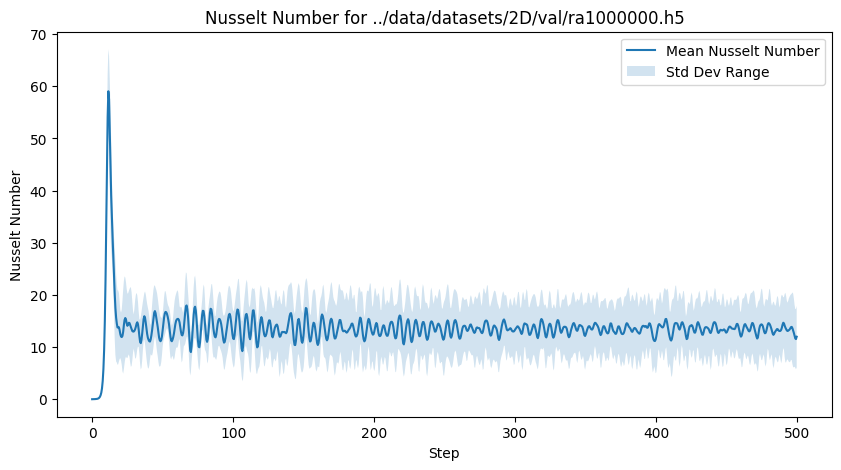

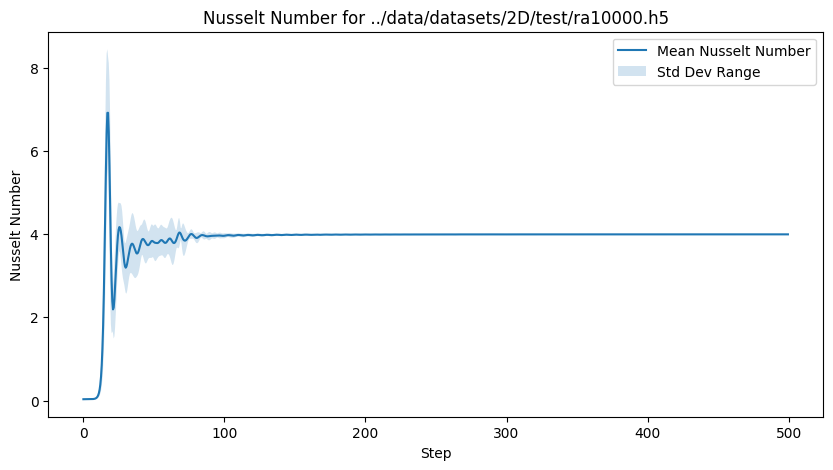

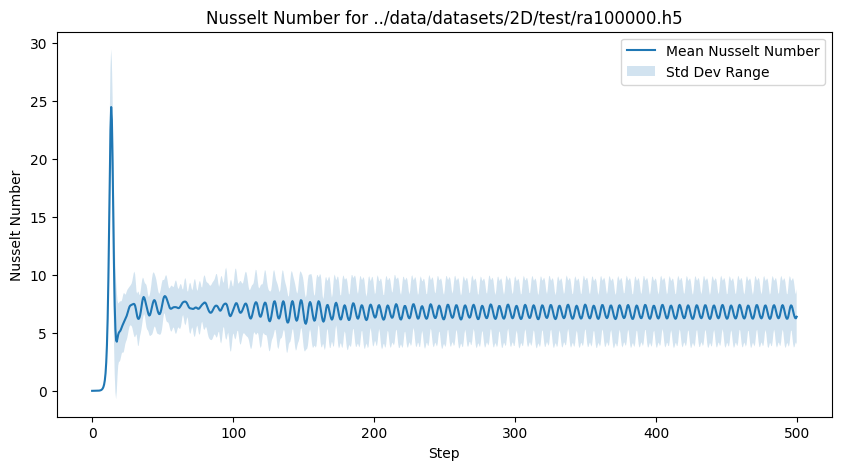

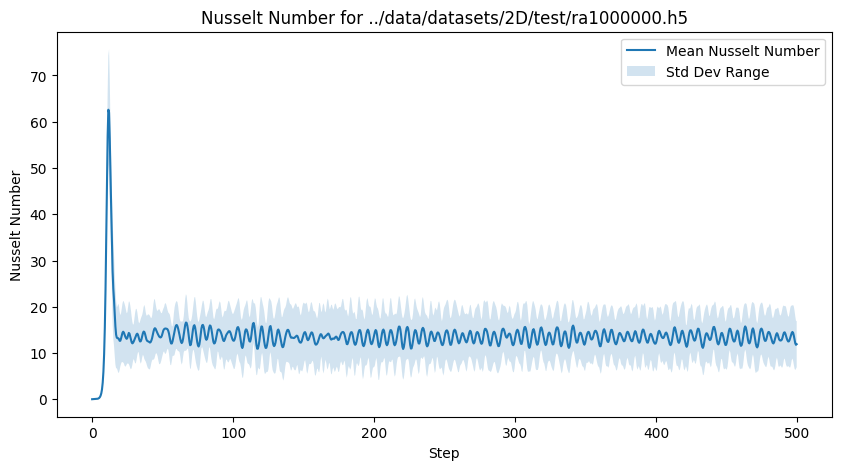

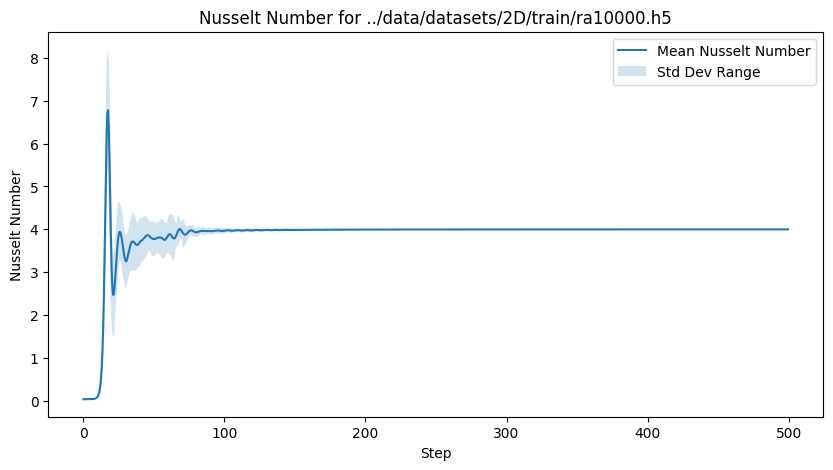

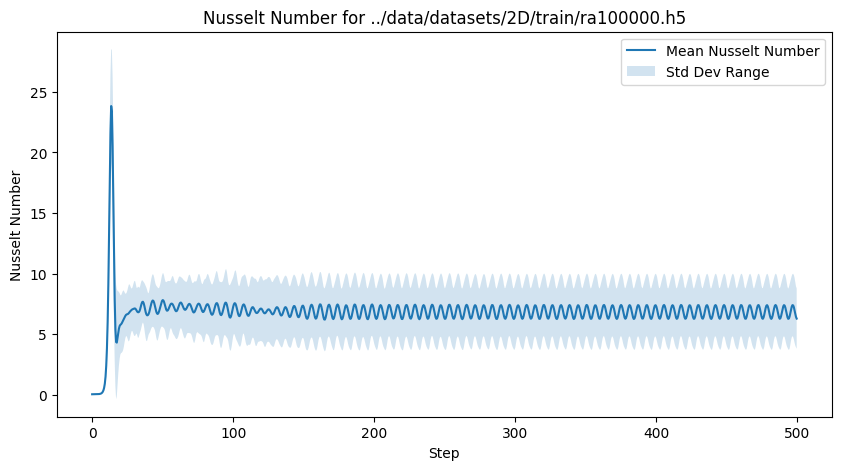

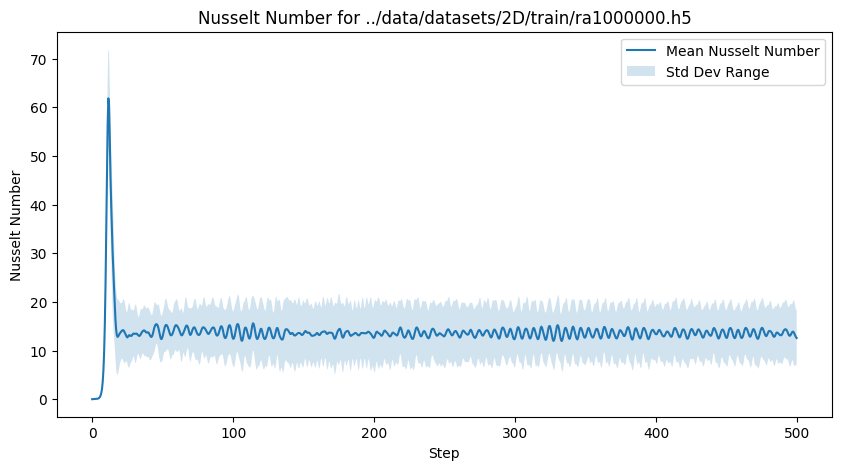

In [82]:
def nu(file, path):
    episodes = file.attrs["episodes"]
    dt = file.attrs["dt"]
    steps = file.attrs["steps"]
    time = np.arange(0, steps * dt, dt)

    nus = []
    for episode in range(episodes):
        # print mean, min, max per channel
        nus.append(np.array(file[f"nusselts{episode}"]))
    nus = np.array(nus)
    mean_nu = nus.mean(axis=0)
    std_nu = nus.std(axis=0)

    # plot musselt to step
    plt.figure(figsize=(10, 5))
    plt.plot(time, mean_nu, label="Mean Nusselt Number")
    plt.fill_between(
        time, mean_nu - std_nu, mean_nu + std_nu, alpha=0.2, label="Std Dev Range"
    )
    plt.legend()
    plt.title(f"Nusselt Number for {path}")
    plt.xlabel("Step")
    plt.ylabel("Nusselt Number")
    plt.show()


for split in splits:
    for ra in ras:
        path = f"../data/datasets/2D/{split}/ra{ra}.h5"
        with h5py.File(path, "r") as file:
            nu(file, path)